In [167]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [168]:
def get_data(filename):
    data = pd.read_csv(filename, names=['Time', 'Voltage'], dtype={"Time": "string", "Voltage": "string"})
    data = data[2:]
    data['Time'] = pd.to_numeric(data['Time'])
    data['Voltage'] = pd.to_numeric(data['Voltage'])
    data['Time'] += abs(data['Time'].iloc[0])
    
    return data

In [169]:
data1 = get_data('data/B/scope_8_1.csv')
data2 = get_data('data/B/scope_8_2.csv')

In [170]:
data1

,Time,Voltage
2,0.000000e+00,2.11814
3,2.560000e-08,2.11814
4,5.120010e-08,2.11814
5,7.680000e-08,2.11814
6,1.024001e-07,2.13824
...,...,...
1562497,3.999987e-02,2.21864
1562498,3.999990e-02,2.21864
1562499,3.999992e-02,2.19854
1562500,3.999995e-02,2.21864


In [171]:
data2

,Time,Voltage
2,0.000000e+00,0.206758
3,2.559990e-08,0.206758
4,5.120000e-08,0.208768
5,7.679990e-08,0.208768
6,1.024000e-07,0.206758
...,...,...
1562497,3.999987e-02,0.216808
1562498,3.999990e-02,0.218818
1562499,3.999992e-02,0.218818
1562500,3.999995e-02,0.218818


In [172]:
voltage_diff = data1['Voltage'] - data2['Voltage']
data_diff = pd.DataFrame({'Time': data1['Time'], 'Voltage': voltage_diff})

In [173]:
data_diff

,Time,Voltage
2,0.000000e+00,1.911382
3,2.560000e-08,1.911382
4,5.120010e-08,1.909372
5,7.680000e-08,1.909372
6,1.024001e-07,1.931482
...,...,...
1562497,3.999987e-02,2.001832
1562498,3.999990e-02,1.999822
1562499,3.999992e-02,1.979722
1562500,3.999995e-02,1.999822


In [174]:
data_diff_trim = data_diff

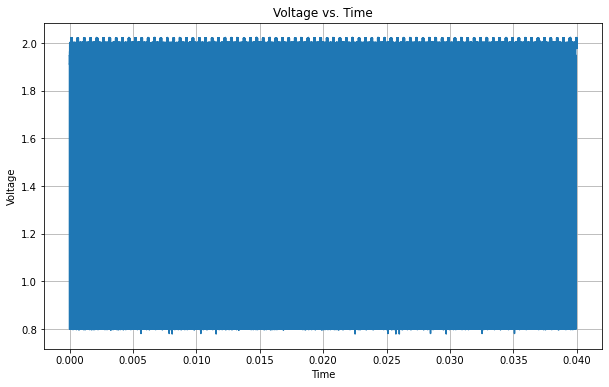

In [175]:
plt.figure(figsize=(10, 6))
plt.plot(data_diff_trim['Time'], data_diff_trim['Voltage'], marker='', linestyle='-')
plt.title('Voltage vs. Time')
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.grid(True)
plt.show()

In [176]:
voltage = np.array(data_diff_trim['Voltage'])
time = np.array(data_diff_trim['Time'])

In [177]:
# voltage thresholds (paper)
#   rising edge = 0.85 V
#   falling edge = 0.2 V
# voltage thresholds (used)
#   rising edge = 1.4 V
#   falling edge = 1.4 V

# TODO: use differnt thresholds to improve accuracy

In [178]:
# convert to square wave
thresh = 1.4
voltage_square = np.where(voltage > thresh, 1, 0)
voltage_square

array([1, 1, 1, ..., 1, 1, 1])

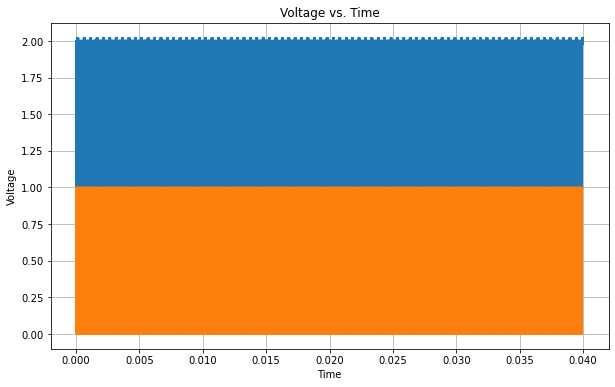

In [179]:
plt.figure(figsize=(10, 6))
plt.plot(data_diff_trim['Time'], data_diff_trim['Voltage'], marker='', linestyle='-')
plt.plot(time, voltage_square, marker='', linestyle='-')
plt.title('Voltage vs. Time')
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.grid(True)
plt.show()

In [180]:
transition_idx = np.where(np.diff(voltage_square) != 0)[0] + 1
transition_idx

array([     51,     209,     521, ..., 1558347, 1558502, 1558816])

In [181]:
transition_time = time[transition_idx]
transition_time

array([1.30560010e-06, 5.35040000e-06, 1.33376000e-05, ...,
       3.98936832e-02, 3.98976512e-02, 3.99056896e-02])

In [182]:
transition_time_diff = np.diff(transition_time)
transition_time_diff

array([4.0447999e-06, 7.9872000e-06, 4.0192000e-06, ..., 3.9936000e-06,
       3.9680000e-06, 8.0384000e-06])

In [191]:
# TODO: get 0 and 1 correct
transition_time_diff_1 = transition_time_diff[::2]
transition_time_diff_0 = transition_time_diff[1::2]
transition_time_diff_1

array([4.0447999e-06, 4.0192000e-06, 8.0640000e-06, ..., 4.0704000e-06,
       3.9936000e-06, 8.0384000e-06])

In [192]:
# TODO: remove inter-frame gap
transition_time_diff_1 = transition_time_diff_1[transition_time_diff_1 <= 0.00001]
transition_time_diff_1

array([4.0447999e-06, 4.0192000e-06, 8.0640000e-06, ..., 4.0704000e-06,
       3.9936000e-06, 8.0384000e-06])

In [193]:
threshold = 0.0000045
indices = np.where(transition_time_diff_1 > threshold)[0]

new_vals = []

for index in indices:
    value = transition_time_diff_1[index]
    new_vals.append(value/2)
    new_vals.append(value/2)

transition_time_diff_1 = np.delete(transition_time_diff_1, indices)

transition_time_diff_1 = np.append(transition_time_diff_1, new_vals)

In [195]:
np.std(transition_time_diff_1)

1.4030799375346855e-08

In [187]:
# 4.028273696590262e-06
# 3.969132610430705e-06

# 4.0258128437643386e-06
# 3.971959847519801e-06

In [188]:
# bit time approx
# 500*10^3 bits per second
# 2*10^6 seconds per bit
# experimental bit rate is 4*10^6 seconds per bit

In [189]:
# 645,000 sps

In [190]:
# max data points is 2,000,000 (2 Mhz)
# we want 50,000,000 sps
# 0.04 sec to get same sampleing rate

# 1 frame is 441*10^-6 s
# 0.04 sec / 441*10^-6 s ~= 90 frames

# bitrate = 500*10^3 bps
# 1 frame ~80 bits
# 1 frame = 0.00016 seconds = 160 * 10^-6 s

# timeout > .5 ms = 1 ms

# 0.04/10 = 0.004 = 4ms

# 45 frames / 5 = 9 data points

# 1 = LOW
# 2 = HIGH
# diff = 1-2